# Random Forest Baseline Classifier for ANES Data

This notebook implements a Random Forest classifier as a simpler baseline model for comparison with the main Prospect Theory LLM pipeline. The goal is to provide a straightforward, traditional machine learning model that is expected to yield lower scores than the deep learning models, thus highlighting the value added by the more complex pipeline.

## 1. Introduction

The main pipeline utilizes advanced deep learning techniques, including fine-tuned LLMs and Prospect Theory concepts, for classifying ANES survey respondents. To demonstrate the efficacy of such a sophisticated approach, it is crucial to establish a baseline using a simpler model. A Random Forest classifier, known for its robustness and interpretability in traditional machine learning, serves as an excellent candidate for this baseline. It operates on structured features extracted from the ANES data, without relying on complex textual embeddings or neural network architectures.

## 2. Setup and Imports

First, let"s import the necessary libraries.

In [1]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure src modules are in path for local import
import sys
sys.path.append(".")
from src.dataset import ProspectTheoryDataset, extract_legitimate_features, extract_target_response
from src.utils import set_seed, create_directory_structure
from src.visualize import plot_confusion_matrix # Re-using existing visualization utility


/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3. Configuration

Define parameters for the baseline model and data paths.

In [2]:
# Configuration Parameters
ANES_DATA_PATH = "/home/tsultanov/shared/datasets/respondents"  # Path to your ANES JSON files
PROCESSED_ANES_DATASET_PATH = "data/anes/anes_structured_dataset.json" # Path to save processed ANES dataset
SEED = 42
N_ESTIMATORS = 100 # Number of trees in Random Forest
MAX_DEPTH = 10 # Max depth of trees to prevent overfitting
USE_OVERSAMPLING = True # Enable/disable SMOTE oversampling
N_SPLITS_KFOLD = 5 # Number of splits for k-fold cross-validation
RESULTS_DIR = "results_random_forest_baseline"
TARGET_NAMES = ["Trump", "Harris"]
TARGET_VARIABLE = "V241049" # WHO WOULD R VOTE FOR: HARRIS VS TRUMP
INCLUDE_CLASSES = ["Donald Trump", "Kamala Harris"]

# Set random seed for reproducibility
set_seed(SEED)

# Create necessary directories
create_directory_structure()
os.makedirs(RESULTS_DIR, exist_ok=True)


Set random seed to 42
Created directory structure: data, models, results


## 4. Data Loading and Preprocessing

For a traditional machine learning model like Random Forest, we need to extract structured numerical and categorical features from the ANES JSON files. The `extract_legitimate_features` function from `src.dataset` will be used, but we will focus on the `structured_features` it returns.

We will also perform standard preprocessing steps such as handling missing values, one-hot encoding categorical features, and scaling numerical features.

In [3]:
def load_and_preprocess_anes_data(json_folder: str, output_path: str, target_variable: str, include_classes: list):
    """
    Loads ANES JSON files, extracts structured features, and saves to a JSON file.
    """
    if os.path.exists(output_path):
        print(f"Processed ANES structured dataset already exists at {output_path}. Loading...")
        with open(output_path, "r") as f:
            return json.load(f)

    print(f"Processing ANES JSON files from {json_folder}...")
    dataset = []
    
    for filename in os.listdir(json_folder):
        if not filename.endswith(".json"):
            continue
            
        filepath = os.path.join(json_folder, filename)
        
        try:
            with open(filepath, "r") as f:
                respondent_data = json.load(f)
            
            # Extract features and target
            _, structured_features = extract_legitimate_features(respondent_data.get("responses", []))
            target_response = extract_target_response(respondent_data.get("responses", []), target_variable)
            
            if target_response not in include_classes:
                continue
            
            target_label = include_classes.index(target_response)
            
            entry = {
                "features": structured_features,
                "target": target_label
            }
            dataset.append(entry)
            
        except Exception as e:
            print(f"Error processing {filename}: {e}")
            continue
            
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with open(output_path, "w") as f:
        json.dump(dataset, f, indent=2)
    print(f"Processed {len(dataset)} samples and saved to {output_path}")
    return dataset

# Load and preprocess data
anes_structured_data = load_and_preprocess_anes_data(ANES_DATA_PATH, PROCESSED_ANES_DATASET_PATH, TARGET_VARIABLE, INCLUDE_CLASSES)

# Convert to DataFrame for easier preprocessing
df = pd.DataFrame([d["features"] for d in anes_structured_data])
df["target"] = [d["target"] for d in anes_structured_data]

# Identify categorical and numerical features
categorical_features = [col for col in df.columns if df[col].dtype == "object" and col != "target"]
numerical_features = [col for col in df.columns if df[col].dtype != "object" and col != "target"]

# Preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[("scaler", StandardScaler())]) 

categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))]) 

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ])

X = df.drop("target", axis=1)
y = df["target"]

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print(f"Class distribution: {Counter(y)}")


Processing ANES JSON files from /home/tsultanov/shared/datasets/respondents...
Error processing respondent_224929.json: 'campaign_interest_num'
Error processing respondent_217485.json: 'campaign_interest_num'
Error processing respondent_238492.json: 'campaign_interest_num'
Error processing respondent_229021.json: 'campaign_interest_num'
Error processing respondent_213130.json: 'campaign_interest_num'
Error processing respondent_239693.json: 'campaign_interest_num'
Error processing respondent_231354.json: 'campaign_interest_num'
Error processing respondent_207232.json: 'campaign_interest_num'
Error processing respondent_225443.json: 'campaign_interest_num'
Error processing respondent_201859.json: 'campaign_interest_num'
Error processing respondent_202695.json: 'campaign_interest_num'
Error processing respondent_228090.json: 'campaign_interest_num'
Error processing respondent_234280.json: 'campaign_interest_num'
Error processing respondent_232065.json: 'campaign_interest_num'
Error proce

## 5. K-Fold Cross-Validation and Training

We will use K-Fold cross-validation to train and evaluate the Random Forest model, providing a robust performance estimate. SMOTE oversampling will be applied to the training data within each fold if `USE_OVERSAMPLING` is set to `True` to address class imbalance.

In [4]:
kf = KFold(n_splits=N_SPLITS_KFOLD, shuffle=True, random_state=SEED)

all_fold_metrics = []
all_fold_confusion_matrices = []

for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
    print(f"\n--- Fold {fold+1}/{N_SPLITS_KFOLD} ---")
    
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Create a pipeline that first preprocesses and then trains the Random Forest
    model_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                   ("classifier", RandomForestClassifier(n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH, random_state=SEED, class_weight="balanced"))])
    
    # Apply SMOTE oversampling if enabled
    if USE_OVERSAMPLING:
        print(f"Applying SMOTE oversampling for Fold {fold+1}...")
        # SMOTE needs numerical data, so we apply preprocessor first
        X_train_processed = preprocessor.fit_transform(X_train)
        
        sm = SMOTE(random_state=SEED)
        X_resampled, y_resampled = sm.fit_resample(X_train_processed, y_train)
        
        print(f"Original train samples: {len(X_train)}, Resampled train samples: {len(X_resampled)}")
        
        # Train the classifier on resampled data (preprocessor already fitted)
        # We need to re-create the pipeline without the preprocessor step for training on resampled data
        # Or, more simply, train the classifier directly on X_resampled
        classifier = RandomForestClassifier(n_estimators=N_ESTIMATORS, max_depth=MAX_DEPTH, random_state=SEED, class_weight="balanced")
        classifier.fit(X_resampled, y_resampled)
        
        # Transform validation data using the fitted preprocessor
        X_val_processed = preprocessor.transform(X_val)
        y_pred = classifier.predict(X_val_processed)
        y_prob = classifier.predict_proba(X_val_processed)[:, 1] # Probability of the positive class

    else:
        # Train the full pipeline directly
        model_pipeline.fit(X_train, y_train)
        y_pred = model_pipeline.predict(X_val)
        y_prob = model_pipeline.predict_proba(X_val)[:, 1] # Probability of the positive class

    # Evaluate performance
    report = classification_report(y_val, y_pred, target_names=TARGET_NAMES, output_dict=True)
    cm = confusion_matrix(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_val, y_pred, target_names=TARGET_NAMES))
    
    all_fold_metrics.append({
        "accuracy": accuracy,
        "macro_precision": report["macro avg"]["precision"],
        "macro_recall": report["macro avg"]["recall"],
        "macro_f1": report["macro avg"]["f1-score"],
        "weighted_precision": report["weighted avg"]["precision"],
        "weighted_recall": report["weighted avg"]["recall"],
        "weighted_f1": report["weighted avg"]["f1-score"]
    })
    all_fold_confusion_matrices.append(cm)



--- Fold 1/5 ---
Applying SMOTE oversampling for Fold 1...
Original train samples: 2188, Resampled train samples: 2394
Accuracy: 0.5529
              precision    recall  f1-score   support

       Trump       0.00      0.00      0.00       245
      Harris       0.55      1.00      0.71       303

    accuracy                           0.55       548
   macro avg       0.28      0.50      0.36       548
weighted avg       0.31      0.55      0.39       548


--- Fold 2/5 ---
Applying SMOTE oversampling for Fold 2...
Original train samples: 2189, Resampled train samples: 2406


/home/tsultanov/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tsultanov/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tsultanov/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tsultan

Accuracy: 0.5430
              precision    recall  f1-score   support

       Trump       0.00      0.00      0.00       250
      Harris       0.54      1.00      0.70       297

    accuracy                           0.54       547
   macro avg       0.27      0.50      0.35       547
weighted avg       0.29      0.54      0.38       547


--- Fold 3/5 ---
Applying SMOTE oversampling for Fold 3...
Original train samples: 2189, Resampled train samples: 2378
Accuracy: 0.4314
              precision    recall  f1-score   support

       Trump       0.43      1.00      0.60       236
      Harris       0.00      0.00      0.00       311

    accuracy                           0.43       547
   macro avg       0.22      0.50      0.30       547
weighted avg       0.19      0.43      0.26       547


--- Fold 4/5 ---
Applying SMOTE oversampling for Fold 4...
Original train samples: 2189, Resampled train samples: 2444


/home/tsultanov/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tsultanov/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tsultanov/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tsultan

Accuracy: 0.4918
              precision    recall  f1-score   support

       Trump       0.49      1.00      0.66       269
      Harris       0.00      0.00      0.00       278

    accuracy                           0.49       547
   macro avg       0.25      0.50      0.33       547
weighted avg       0.24      0.49      0.32       547


--- Fold 5/5 ---
Applying SMOTE oversampling for Fold 5...
Original train samples: 2189, Resampled train samples: 2378
Accuracy: 0.5686
              precision    recall  f1-score   support

       Trump       0.00      0.00      0.00       236
      Harris       0.57      1.00      0.72       311

    accuracy                           0.57       547
   macro avg       0.28      0.50      0.36       547
weighted avg       0.32      0.57      0.41       547



/home/tsultanov/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tsultanov/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tsultanov/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tsultan

## 6. Aggregated Results and Evaluation

After training across all folds, we aggregate the results to get a comprehensive evaluation of the baseline model.


Aggregating results from all folds...

Final Aggregated Evaluation Results (K-Fold Cross-Validation):
Average Accuracy: 0.5175
Average Macro Precision: 0.2588
Average Macro Recall: 0.5000
Average Macro F1-Score: 0.3403
Average Weighted Precision: 0.2704
Average Weighted Recall: 0.5175
Average Weighted F1-Score: 0.3545
Average Confusion Matrix: [[101.  146.2]
 [117.8 182.2]]
Aggregated K-Fold results saved to results_random_forest_baseline/aggregated_kfold_results_rf_baseline.json
Saved confusion matrix to results_random_forest_baseline/average_confusion_matrix_rf_baseline.png


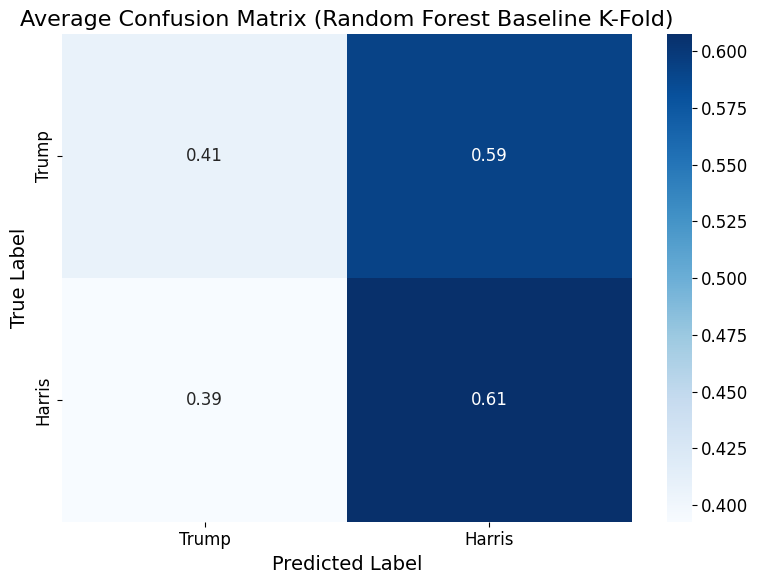


Random Forest Baseline pipeline complete! Results saved to {RESULTS_DIR}


In [ ]:
print("\nAggregating results from all folds...")

avg_accuracy = np.mean([m["accuracy"] for m in all_fold_metrics])
avg_macro_precision = np.mean([m["macro_precision"] for m in all_fold_metrics])
avg_macro_recall = np.mean([m["macro_recall"] for m in all_fold_metrics])
avg_macro_f1 = np.mean([m["macro_f1"] for m in all_fold_metrics])
avg_weighted_precision = np.mean([m["weighted_precision"] for m in all_fold_metrics])
avg_weighted_recall = np.mean([m["weighted_recall"] for m in all_fold_metrics])
avg_weighted_f1 = np.mean([m["weighted_f1"] for m in all_fold_metrics])
avg_confusion_matrix = np.mean(all_fold_confusion_matrices, axis=0)

print("\nFinal Aggregated Evaluation Results (K-Fold Cross-Validation):")
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Macro Precision: {avg_macro_precision:.4f}")
print(f"Average Macro Recall: {avg_macro_recall:.4f}")
print(f"Average Macro F1-Score: {avg_macro_f1:.4f}")
print(f"Average Weighted Precision: {avg_weighted_precision:.4f}")
print(f"Average Weighted Recall: {avg_weighted_recall:.4f}")
print(f"Average Weighted F1-Score: {avg_weighted_f1:.4f}")
print("Average Confusion Matrix:\
", avg_confusion_matrix)

# Save aggregated results
aggregated_results = {
    "average_accuracy": avg_accuracy,
    "average_macro_precision": avg_macro_precision,
    "average_macro_recall": avg_macro_recall,
    "average_macro_f1": avg_macro_f1,
    "average_weighted_precision": avg_weighted_precision,
    "average_weighted_recall": avg_weighted_recall,
    "average_weighted_f1": avg_weighted_f1,
    "average_confusion_matrix": avg_confusion_matrix.tolist()
}

with open(os.path.join(RESULTS_DIR, "aggregated_kfold_results_rf_baseline.json"), "w") as f:
    json.dump(aggregated_results, f, indent=2)
print(f"Aggregated K-Fold results saved to {os.path.join(RESULTS_DIR, 'aggregated_kfold_results_rf_baseline.json')}")

# Generate overall visualizations from aggregated data
try:
    plot_confusion_matrix(
        avg_confusion_matrix, 
        target_names=TARGET_NAMES, 
        save_path=os.path.join(RESULTS_DIR, "average_confusion_matrix_rf_baseline.png"),
        title="Average Confusion Matrix (Random Forest Baseline K-Fold)"
    )
except Exception as e:
    print(f"Error generating average confusion matrix plot: {e}")

print("\nRandom Forest Baseline pipeline complete! Results saved to {RESULTS_DIR}")


## 7. Conclusion

This notebook provides a robust Random Forest baseline for comparison. The aggregated metrics from the K-Fold cross-validation offer a reliable measure of its performance. You can now compare these results with those from your main Prospect Theory LLM pipeline to quantify the impact of your advanced techniques. This model is intentionally kept simpler and is expected to yield lower scores, serving as a clear lower bound for performance.